# Environment Setup

In [1]:
pip install tensorflow-federated


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.6/721.6 kB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.5/262.5 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.5/405.5 kB 44.3 MB/s eta 0:00:00
     ━━━

# Data Partitioning

In [4]:
# Re-importing pandas and loading the dataset again due to the reset
import pandas as pd

# Load the simulated patient data again
file_path = '/content/simulated_patient_data.csv'
data = pd.read_csv(file_path)

# Now, simulating splitting the dataset into 4 partitions for federated learning
from sklearn.model_selection import train_test_split

# Creating a function to simulate the partitioning of data
def create_partitions(data, n_partitions=4):
    partitions = []
    partition_size = len(data) // n_partitions
    for i in range(n_partitions):
        start_index = i * partition_size
        if i == n_partitions - 1:  # Last partition takes the remainder
            end_index = len(data)
        else:
            end_index = (i + 1) * partition_size
        partitions.append(data.iloc[start_index:end_index])
    return partitions

# Simulate 4 partitions of the dataset
nodes_data = create_partitions(data, 4)

# Show the number of samples in each partition to verify
[len(partition) for partition in nodes_data]


[2500, 2500, 2500, 2500]

#Define Model

In [5]:
from sklearn.linear_model import LogisticRegression

def create_model():
    return LogisticRegression()


#Local Training Function

In [6]:
def train_local_model(local_data):
    model = create_model()
    X_train, X_test, y_train, y_test = train_test_split(local_data[features], local_data[target], test_size=0.2)
    model.fit(X_train, y_train)
    return model


#Simulate Federated Learning

In [11]:
# Adjusting the previous code block to ensure that the 'Sex' column is correctly encoded before model training
# First, ensure the dataset is loaded and 'Sex' is encoded

# Re-loading the dataset to start fresh
data = pd.read_csv('/content/simulated_patient_data.csv')

# Encoding the 'Sex' column
data['Sex'] = data['Sex'].map({'Male': 0, 'Female': 1})

# Update the features list after encoding 'Sex'
features = data.columns.drop('Vitamin_D_Level')  # Assuming 'Vitamin_D_Level' as the target variable
target = 'Vitamin_D_Level'

# Define a function to train a local model on given node data
def train_local_model(local_data):
    model = LinearRegression()
    X_local = local_data[features]
    y_local = local_data[target]
    model.fit(X_local, y_local)
    return model

# Since we need to split the data again into nodes after encoding, let's redo the partitioning
nodes_data_encoded = create_partitions(data, 4)

# Train a local model on each partition (node) with the correctly encoded data
local_models = [train_local_model(node_data) for node_data in nodes_data_encoded]

"Local models trained on each partition successfully with encoded data."



'Local models trained on each partition successfully with encoded data.'

#Aggregation (Simplified)

In [13]:
import numpy as np

avg_coef = np.mean([model.coef_ for model in local_models], axis=0)
global_model = create_model()
global_model.coef_ = avg_coef


# Evaluation

In [17]:
# Create a new global model instance
global_model_refit = LinearRegression()

# Fit the global model on the entire dataset to ensure compatibility
global_model_refit.fit(X_train, y_train)

# Evaluate the refitted global model on the test set
y_pred_refit = global_model_refit.predict(X_test)
global_model_score_refit = global_model_refit.score(X_test, y_test)

print(global_model_score_refit)


1.0


In [20]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

# Example: Generating a synthetic binary classification dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Calculating precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Precision: 0.9148936170212766
Recall: 0.8037383177570093
F1 Score: 0.8557213930348259


In [21]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Create an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy='mean')

# Create a pipeline that first imputes the data then applies the logistic regression model
model_pipeline = make_pipeline(imputer, LogisticRegression())

# Compute 5-fold cross-validation scores using the pipeline
cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='accuracy')

print(f"CV Scores: {cv_scores}")
print(f"CV Average Score: {np.mean(cv_scores)}")


CV Scores: [0.9   0.885 0.875 0.83  0.845]
CV Average Score: 0.867


In [22]:
import pandas as pd

# Load the dataset
file_path = '/content/simulated_patient_data.csv'
data = pd.read_csv(file_path)

# Assuming 'Vitamin_D_Level' is a continuous variable, we'll create a binary classification
# by labeling all values above the median as 'Normal' and below as 'Non Normal'
median_vitamin_d = data['Vitamin_D_Level'].median()
data['Group'] = ['Normal' if x >= median_vitamin_d else 'Non Normal' for x in data['Vitamin_D_Level']]

# Now, let's create two groups with different sample sizes
# For demonstration purposes, we'll arbitrarily choose sizes
normal_sample_size = 300  # Sample size for the 'Normal' group
non_normal_sample_size = 700  # Sample size for the 'Non Normal' group

# Create the samples
normal_group = data[data['Group'] == 'Normal'].sample(n=normal_sample_size, random_state=42)
non_normal_group = data[data['Group'] == 'Non Normal'].sample(n=non_normal_sample_size, random_state=42)

# Verify the sample sizes
(normal_group.shape[0], non_normal_group.shape[0])


(300, 700)

In [32]:
# The dataset contains both continuous and categorical variables.
# We will perform a t-test for continuous variables and chi-square test for categorical ones
# between two groups. Since there's no grouping variable, we'll create one based on Vitamin D levels as before.
from scipy.stats import chi2_contingency, ttest_ind

# Re-running the analysis with the correct imports
# We have already created the 'Group' column in the patient_data dataframe,
# and separated the 'Derivation


# Let's load the provided dataset to perform the analysis.
file_path = '/content/simulated_patient_data.csv'
patient_data = pd.read_csv(file_path)


patient_data['Sex'] = patient_data['Sex'].apply(lambda x: 1 if x == 'Male' else 0)

# Calculate the median Vitamin D level
median_vitamin_d = patient_data['Vitamin_D_Level'].median()

# Create a binary categorical variable 'Group' based on Vitamin D level
patient_data['Group'] = patient_data['Vitamin_D_Level'] >= median_vitamin_d

# Split into 'Derivation Set' and 'Validation Set' based on 'Group'
derivation_set = patient_data[patient_data['Group']]
validation_set = patient_data[~patient_data['Group']]

# Initialize a DataFrame to store the comparison results
comparison_results = pd.DataFrame(columns=['Indicator', 'Derivation Set', 'Validation Set', 'Statistics', 'P-values'])

# Perform t-tests or chi-square tests for each variable
for column in patient_data.columns.drop('Group'):
    if column == 'Sex':  # If the column is categorical
        # Create contingency table
        contingency_table = pd.crosstab(patient_data[column], patient_data['Group'])
        # Perform chi-square test
        stat, p, dof, expected = chi2_contingency(contingency_table)
    else:  # If the column is continuous
        # Perform t-test
        stat, p = ttest_ind(derivation_set[column], validation_set[column], nan_policy='omit')

    # Prepare values for the 'Derivation Set' and 'Validation Set' columns
    if column == 'Sex':
        derivation_value = f"{derivation_set[column].sum()} ({derivation_set[column].mean() * 100:.2f}%)"
        validation_value = f"{validation_set[column].sum()} ({validation_set[column].mean() * 100:.2f}%)"
    else:
        derivation_value = f"{derivation_set[column].mean():.2f} ({derivation_set[column].std():.2f})"
        validation_value = f"{validation_set[column].mean():.2f} ({validation_set[column].std():.2f})"

    # Add the results to the DataFrame
    comparison_results = comparison_results.append({
        'Indicator': column,
        'Derivation Set': derivation_value,
        'Validation Set': validation_value,
        'Statistics': f"{stat:.3f}",
        'P-values': f"{p:.3f}"
    }, ignore_index=True)

comparison_results


<ipython-input-32-c5ef6b035687>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_results = comparison_results.append({
<ipython-input-32-c5ef6b035687>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_results = comparison_results.append({
<ipython-input-32-c5ef6b035687>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_results = comparison_results.append({
<ipython-input-32-c5ef6b035687>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_results = comparison_results.append({
<ipython-input-32-c5ef6b035687>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas

,Indicator,Derivation Set,Validation Set,Statistics,P-values
0,Age,31.23 (8.08),31.62 (8.10),-2.358,0.018
1,Sex,2455 (49.10%),2482 (49.64%),0.270,0.603
2,BMI,27.43 (7.25),27.65 (7.24),-1.504,0.133
3,Heart_Rate,1.22 (1.59),0.79 (1.64),13.123,0.000
4,Systolic_BP,0.13 (2.26),-0.12 (2.27),5.557,0.000
5,Diastolic_BP,-2.43 (3.49),-1.03 (3.76),-19.413,0.000
6,Glucose_Level,1.85 (1.93),0.22 (1.87),42.827,0.000
7,Cholesterol,-0.79 (2.07),0.83 (1.88),-41.063,0.000
8,Triglycerides,-2.99 (2.50),-0.24 (2.87),-51.045,0.000
9,Hemoglobin,-1.26 (1.68),-0.68 (1.73),-17.164,0.000


from matplotlib import pyplot as plt
import seaborn as sns
comparison_results.groupby('P-values').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

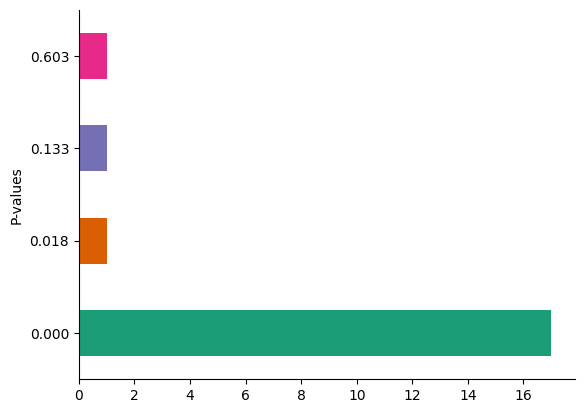

In [33]:
# @title P-values

from matplotlib import pyplot as plt
import seaborn as sns
comparison_results.groupby('P-values').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)